### Potrzebne importy, wstępna konfiguracja

In [36]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from collections import Counter

from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [37]:
device = torch.device('cuda') # torch.device('cpu')
device

device(type='cuda')

In [38]:
rng = np.random.default_rng(73512)

### Przygotowanie danych (wraz z paddingiem)

In [39]:
train_data = pd.read_pickle('train.pkl')
test_data = pd.read_pickle('test_no_target.pkl')

In [41]:
all_elements = []
for i in train_data:
    for j in i[0]:
        all_elements.append(j)
elements_count = Counter(all_elements)
print(elements_count)
df.plot(kind="bar")

In [43]:
print(f"Minimalna wartość wśród danych: {min(all_elements)}")
print(f"Maksymalna wartość wśród danych: {max(all_elements)}")

In [44]:
class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(torch.Tensor(x).float(), torch.tensor(y).long()) for x, y in zip(in_data, target)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

    def __print__(self):
        print(self.data)

In [45]:
data = [i[0] for i in train_data]
classes = [i[1] for i in train_data]

In [46]:
len([i for i in classes if i == 0])

1630

In [47]:
train_indices = rng.random(len(data)) > 0.3
train_indices

array([ True,  True,  True, ...,  True,  True,  True])

In [120]:
classes_train = [ x for i, x in enumerate(classes) if train_indices[i]]
classes_valid = [ x for i, x in enumerate(classes) if not train_indices[i]]
data_train = [ x for i, x in enumerate(data) if train_indices[i]]
data_valid = [ x for i, x in enumerate(data) if not train_indices[i]]

In [121]:
train_set = VariableLenDataset(data_train,
                               classes_train)
valid_set = VariableLenDataset(data_valid,
                               classes_valid)
# train_set.__print__()
train_set.__getitem__(1)

(tensor([ -1.,  -1., 144.,  ...,  32.,  -1.,  -1.]), tensor(0))

In [122]:
pad = -2

def pad_collate(batch, pad_value=pad):

    xx, yy = zip(*batch)
    x_lens = [len(x) for x in xx]
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    yy_tensor = torch.stack(yy)

    return xx_pad, yy_tensor, x_lens

In [123]:
def compute_classes_weights(classes):
    classes_count = []
    classes_count.append(len([i for i in classes if i == 0]))
    classes_count.append(len([i for i in classes if i == 1]))
    classes_count.append(len([i for i in classes if i == 2]))
    classes_count.append(len([i for i in classes if i == 3]))
    classes_count.append(len([i for i in classes if i == 4]))
    classes_count = torch.tensor(classes_count)
    weights = 1. / classes_count.float()
    sample_weights = torch.tensor([weights[t] for t in classes])
    return sample_weights

In [124]:
samples_weights_train = compute_classes_weights(classes_train)
samples_weights_valid = compute_classes_weights(classes_valid)

In [160]:
sampler_train = torch.utils.data.WeightedRandomSampler(samples_weights_train, len(samples_weights_train), replacement=True)
sampler_valid = torch.utils.data.WeightedRandomSampler(samples_weights_valid, len(samples_weights_valid), replacement=True)
train_loader = DataLoader(train_set, batch_size=64, collate_fn=pad_collate, sampler=sampler_train)
valid_loader = DataLoader(valid_set, batch_size=64, collate_fn=pad_collate, shuffle=True)

### Model

In [161]:
class LSTM_Seq_Regressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size, bidirectional=False, drop_out=0):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.proj_size = out_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional =1
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, 
                            proj_size = out_size, bidirectional = bidirectional, dropout=drop_out)
        self.fc2 = nn.Linear(hidden_size, out_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers*self.bidirectional, batch_size, self.proj_size)
        state = torch.zeros(self.num_layers*self.bidirectional, batch_size, self.hidden_size)
        return hidden, state

    def forward(self, x, hidden):
        all_outputs, hidden = self.lstm(x, hidden)
        return all_outputs, hidden



### Funkcja do ewaluacji

In [162]:
def eval(loader, net):

    correct_pred = 0
    total_pred = 0
    net.eval()

    with torch.no_grad():
        for x, targets, x_len in loader:
            # images = images.to(device)
            x = x.to(device).unsqueeze(2)
            targets = targets.to(device)

            hidden, state = model.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)

            x_packed = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)
            preds_packed, _ = model(x_packed, (hidden, state))
            preds, pred_len = pad_packed_sequence(preds_packed, batch_first=True, padding_value=pad)

            preds = preds.squeeze(2)
            last_outputs = []
            for i, length in enumerate(pred_len):
                last_outputs.append(preds[i, length -1 , :])
            last_outputs = torch.stack(last_outputs)
            loss = loss_fun(last_outputs, targets)

            _, predictions = torch.max(last_outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(targets, predictions):
                if label == prediction:
                    correct_pred += 1
                total_pred += 1
    return correct_pred/total_pred, loss


### Funkcja zawierająca pętle treeningową modelu

In [182]:
def train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc, learning_rate=0.001, epoch_number=200):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
    loss_fun = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(epoch_number):
        for x, targets, x_len in train_loader:
            # print(f"Trening: {x} oraz {targets}")
            model.train()
            x = x.to(device).unsqueeze(2)
            targets = targets.to(device)
    
            hidden, state = model.init_hidden(x.size(0))
            hidden, state = hidden.to(device), state.to(device)
    
            x_packed = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)
            preds_packed, _ = model(x_packed, (hidden, state))
            preds, pred_len = pad_packed_sequence(preds_packed, batch_first=True, padding_value=pad)
    
            preds = preds.squeeze(2)
            last_outputs = []
            for i, length in enumerate(pred_len):
                last_outputs.append(preds[i, length -1 , :])
            last_outputs = torch.stack(last_outputs)
            optimizer.zero_grad()
            # mask = targets != pad
            # print(mask)
            loss = loss_fun(last_outputs, targets)
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            acc_valid, loss_valid = eval(valid_loader, model)
            acc_train, loss_train = eval(train_loader, model)
            train_loss.append(loss_train)
            valid_loss.append(loss_valid)
            train_acc.append(acc_train)
            valid_acc.append(acc_valid)
            print(f"Epoch: {epoch}, loss train: {loss_train.item():.3}, loss valid: {loss_valid}")
            print(f'Accuracy train: {acc_train}')
            print(f'Accuracy valid: {acc_valid}')

### Funkcja do wyświetlania graficznie poczynań modelu

In [165]:
def plot_metrics(train_loss, valid_loss, train_acc, valid_acc):
    iters_losses = [i for i in range(len(train_loss))]
    iters_acc = [i for i in range(len(train_acc))]
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(iters_losses, train_loss, label="Train")
    plt.plot(iters_losses, valid_loss, label="Valid")
    plt.legend(loc='best')
    plt.ylabel("Loss")
    
    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters_acc, train_acc, label="Train")
    plt.plot(iters_acc, valid_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    
    plt.show()
    
    
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(valid_acc[-1]))


# Ustalanie odpowiedniego samplingu

### Sampling za pomocą WeighteRandomSampler - sampling z powtórzeniami
Wielkość zbiory nie jest zmieniona, każda próbka ma przypisane prawdopodobieństwo, żeby próbki każdej klasy były wybieranie odpowiednio często.

In [124]:
samples_weights_train = compute_classes_weights(classes_train)
samples_weights_valid = compute_classes_weights(classes_valid)

In [160]:
sampler_train = torch.utils.data.WeightedRandomSampler(samples_weights_train, len(samples_weights_train), replacement=True)
sampler_valid = torch.utils.data.WeightedRandomSampler(samples_weights_valid, len(samples_weights_valid), replacement=True)
train_loader = DataLoader(train_set, batch_size=64, collate_fn=pad_collate, sampler=sampler_train)
valid_loader = DataLoader(valid_set, batch_size=64, collate_fn=pad_collate, shuffle=True)

Hidden size = 100 Number of layers = 1

In [166]:
model = LSTM_Seq_Regressor(1, 100, 1, 5).to(device)
model

LSTM_Seq_Regressor(
  (lstm): LSTM(1, 100, proj_size=5)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)

In [167]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

In [168]:
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc)

Epoch: 0, loss train: 1.55, loss valid: 1.6545504331588745
Accuracy train: 0.32576505429417574
Accuracy valid: 0.24644030668127054
Epoch: 10, loss train: 1.23, loss valid: 1.2522075176239014
Accuracy train: 0.5029615004935835
Accuracy valid: 0.4370208105147864
Epoch: 20, loss train: 0.927, loss valid: 1.230544090270996
Accuracy train: 0.577492596248766
Accuracy valid: 0.5859802847754655
Epoch: 30, loss train: 0.894, loss valid: 0.8028404116630554
Accuracy train: 0.6268509378084897
Accuracy valid: 0.628696604600219
Epoch: 40, loss train: 0.918, loss valid: 1.0791187286376953
Accuracy train: 0.6327739387956565
Accuracy valid: 0.6440306681270537
Epoch: 50, loss train: 0.958, loss valid: 0.7647656202316284
Accuracy train: 0.7033563672260612
Accuracy valid: 0.628696604600219
Epoch: 60, loss train: 0.671, loss valid: 0.9057462811470032
Accuracy train: 0.7181638696939783
Accuracy valid: 0.6308871851040526
Epoch: 70, loss train: 0.639, loss valid: 0.5782299637794495
Accuracy train: 0.754195459

In [169]:
train_loss = [x.cpu() for x in train_loss]
valid_loss = [x.cpu() for x in valid_loss]

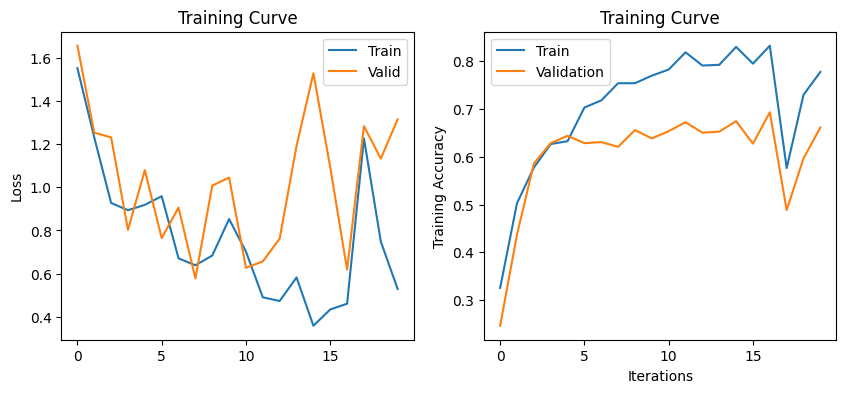

Final Training Accuracy: 0.7778874629812438
Final Validation Accuracy: 0.6615553121577218


In [170]:
plot_metrics(train_loss, valid_loss, train_acc, valid_acc)

### Dla samplingu bez potwórzeń

In [183]:
sampler_train = torch.utils.data.WeightedRandomSampler(samples_weights_train, len(samples_weights_train), replacement=False)
sampler_valid = torch.utils.data.WeightedRandomSampler(samples_weights_valid, len(samples_weights_valid), replacement=False)
train_loader = DataLoader(train_set, batch_size=64, collate_fn=pad_collate, sampler=sampler_train)
valid_loader = DataLoader(valid_set, batch_size=64, collate_fn=pad_collate, shuffle=True)

In [184]:
model = LSTM_Seq_Regressor(1, 100, 1, 5, drop_out=0.3).to(device)
model

LSTM_Seq_Regressor(
  (lstm): LSTM(1, 100, proj_size=5, dropout=0.3)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)

In [189]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

In [190]:
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc)

Epoch: 0, loss train: 0.254, loss valid: 0.9841160774230957
Accuracy train: 0.5888450148075025
Accuracy valid: 0.5991237677984665
Epoch: 10, loss train: 0.271, loss valid: 1.1886627674102783
Accuracy train: 0.6436327739387957
Accuracy valid: 0.6396495071193866
Epoch: 20, loss train: 0.33, loss valid: 1.1868410110473633
Accuracy train: 0.6520236920039487
Accuracy valid: 0.6473165388828039
Epoch: 30, loss train: 0.231, loss valid: 1.101635217666626
Accuracy train: 0.6436327739387957
Accuracy valid: 0.6429353778751369
Epoch: 40, loss train: 0.236, loss valid: 1.6211743354797363
Accuracy train: 0.6599210266535045
Accuracy valid: 0.651697699890471
Epoch: 50, loss train: 0.308, loss valid: 0.9665952324867249
Accuracy train: 0.6658440276406713
Accuracy valid: 0.6549835706462213
Epoch: 60, loss train: 0.346, loss valid: 1.0819330215454102
Accuracy train: 0.6633761105626851
Accuracy valid: 0.6451259583789705
Epoch: 70, loss train: 0.411, loss valid: 0.6599523425102234
Accuracy train: 0.66683119

In [191]:
train_loss = [x.cpu() for x in train_loss]
valid_loss = [x.cpu() for x in valid_loss]

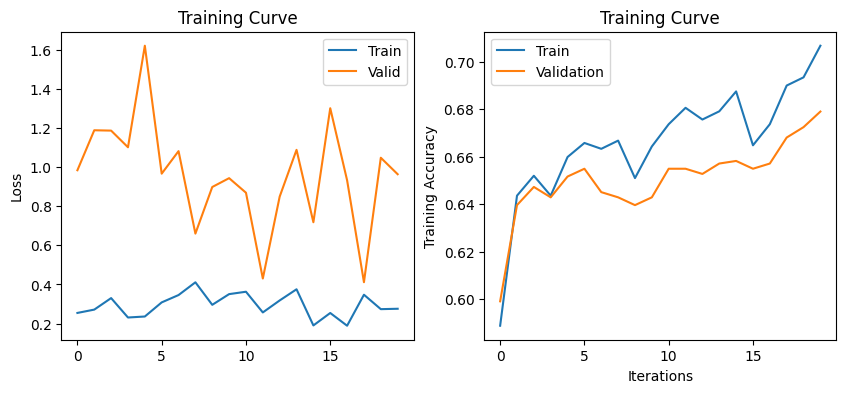

Final Training Accuracy: 0.7068114511352419
Final Validation Accuracy: 0.6790799561883899


In [192]:
plot_metrics(train_loss, valid_loss, train_acc, valid_acc)

#### Dla modelu "bidirectional"

In [196]:
model = LSTM_Seq_Regressor(1, 100, 1, 5, bidirectional=True, drop_out=0.01).to(device)
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc, learning_rate=0.001)

Epoch: 0, loss train: 1.19, loss valid: 1.8513034582138062
Accuracy train: 0.5508390918065152
Accuracy valid: 0.5585980284775466
Epoch: 10, loss train: 0.496, loss valid: 0.7272369265556335
Accuracy train: 0.5533070088845015
Accuracy valid: 0.5575027382256298
Epoch: 20, loss train: 0.464, loss valid: 0.9512159824371338
Accuracy train: 0.56071076011846
Accuracy valid: 0.5662650602409639
Epoch: 30, loss train: 0.378, loss valid: 1.2412450313568115
Accuracy train: 0.596248766041461
Accuracy valid: 0.6133625410733844
Epoch: 40, loss train: 0.402, loss valid: 1.0304033756256104
Accuracy train: 0.6145113524185587
Accuracy valid: 0.6166484118291348
Epoch: 50, loss train: 0.397, loss valid: 1.0088833570480347
Accuracy train: 0.6199407699901284
Accuracy valid: 0.6374589266155531
Epoch: 60, loss train: 0.348, loss valid: 0.6647849082946777
Accuracy train: 0.6253701875616979
Accuracy valid: 0.6210295728368017
Epoch: 70, loss train: 0.333, loss valid: 1.2121198177337646
Accuracy train: 0.642152023

KeyboardInterrupt: 

In [194]:
train_loss = [x.cpu() for x in train_loss]
valid_loss = [x.cpu() for x in valid_loss]

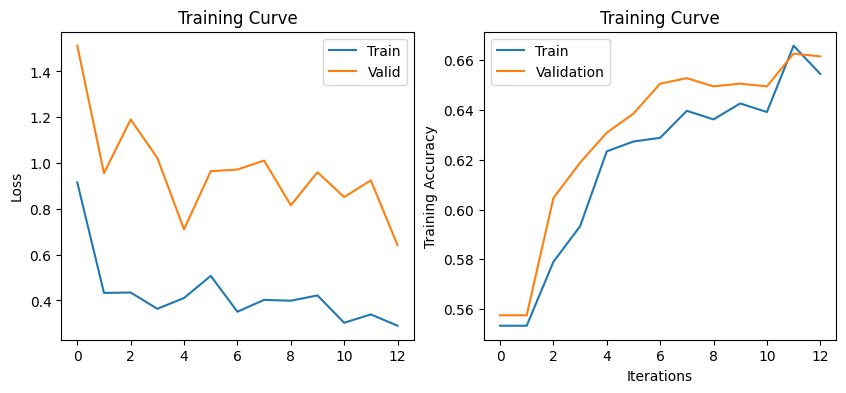

Final Training Accuracy: 0.6544916090819348
Final Validation Accuracy: 0.6615553121577218


In [195]:
plot_metrics(train_loss, valid_loss, train_acc, valid_acc)

## Trenowanie modelu dla samplingu z powtórzeniami

In [210]:
samples_weights_train = compute_classes_weights(classes_train)
samples_weights_valid = compute_classes_weights(classes_valid)

In [211]:
sampler_train = torch.utils.data.WeightedRandomSampler(samples_weights_train, len(samples_weights_train), replacement=True)
sampler_valid = torch.utils.data.WeightedRandomSampler(samples_weights_valid, len(samples_weights_valid), replacement=True)
train_loader = DataLoader(train_set, batch_size=128, collate_fn=pad_collate, sampler=sampler_train)
valid_loader = DataLoader(valid_set, batch_size=128, collate_fn=pad_collate, sampler=sampler_valid)

### Dla hidden = 40, layer = 2, learning rate = 0.005

In [45]:
model = LSTM_Seq_Regressor(1, 40, 2, 5, bidirectional=False, drop_out=0.3).to(device)
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

In [46]:
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc, learning_rate=0.005)

Epoch: 0, loss train: 1.6, loss valid: 1.5856493711471558
Accuracy train: 0.18904244817374136
Accuracy valid: 0.20153340635268346
Epoch: 10, loss train: 1.53, loss valid: 1.562352180480957
Accuracy train: 0.315893385982231
Accuracy valid: 0.29901423877327493
Epoch: 20, loss train: 1.38, loss valid: 1.428261399269104
Accuracy train: 0.3943731490621915
Accuracy valid: 0.3614457831325301
Epoch: 30, loss train: 1.3, loss valid: 1.2557408809661865
Accuracy train: 0.4654491609081935
Accuracy valid: 0.43811610076670315
Epoch: 40, loss train: 1.35, loss valid: 1.3632813692092896
Accuracy train: 0.45113524185587367
Accuracy valid: 0.45454545454545453
Epoch: 50, loss train: 1.12, loss valid: 1.1540160179138184
Accuracy train: 0.4837117472852912
Accuracy valid: 0.47316538882803943
Epoch: 60, loss train: 1.18, loss valid: 0.9794037938117981
Accuracy train: 0.46495557749259625
Accuracy valid: 0.488499452354874
Epoch: 70, loss train: 1.17, loss valid: 0.9767232537269592
Accuracy train: 0.52122408687

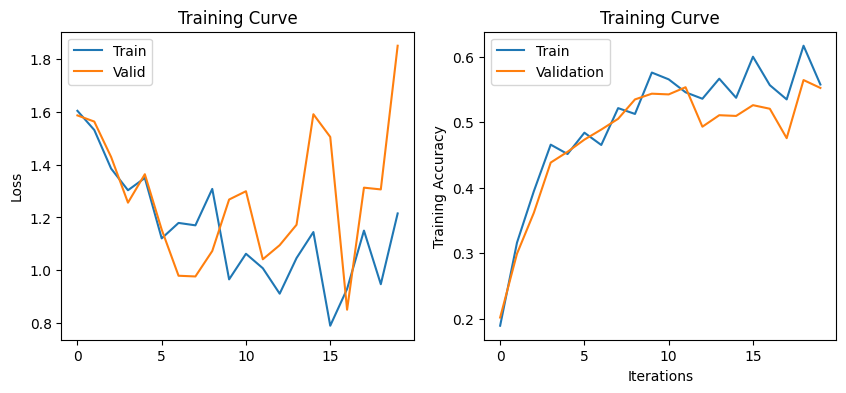

Final Training Accuracy: 0.5572556762092794
Final Validation Accuracy: 0.552026286966046


In [47]:
train_loss = [x.cpu() for x in train_loss]
valid_loss = [x.cpu() for x in valid_loss]
plot_metrics(train_loss, valid_loss, train_acc, valid_acc)

### Dla hidden = 100, layer = 2, learning rate = 0.005

In [212]:
model = LSTM_Seq_Regressor(1, 100, 2, 5, bidirectional=False, drop_out=0.3).to(device)
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

In [217]:
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc, learning_rate=0.005)

Epoch: 0, loss train: 0.886, loss valid: 1.231283187866211
Accuracy train: 0.6456071076011846
Accuracy valid: 0.5969331872946331
Epoch: 10, loss train: 0.807, loss valid: 1.192801833152771
Accuracy train: 0.6683119447186574
Accuracy valid: 0.6024096385542169
Epoch: 20, loss train: 0.813, loss valid: 0.8385030031204224
Accuracy train: 0.6831194471865746
Accuracy valid: 0.6352683461117196
Epoch: 30, loss train: 1.03, loss valid: 1.735737919807434
Accuracy train: 0.684106614017769
Accuracy valid: 0.6122672508214677
Epoch: 40, loss train: 0.711, loss valid: 0.8627468943595886
Accuracy train: 0.702862783810464
Accuracy valid: 0.6177437020810514
Epoch: 50, loss train: 0.891, loss valid: 0.9783696532249451
Accuracy train: 0.6303060217176703
Accuracy valid: 0.5903614457831325
Epoch: 60, loss train: 0.901, loss valid: 0.6933116912841797
Accuracy train: 0.7097729516288253
Accuracy valid: 0.6363636363636364
Epoch: 70, loss train: 0.734, loss valid: 1.2310001850128174
Accuracy train: 0.66831194471

KeyboardInterrupt: 

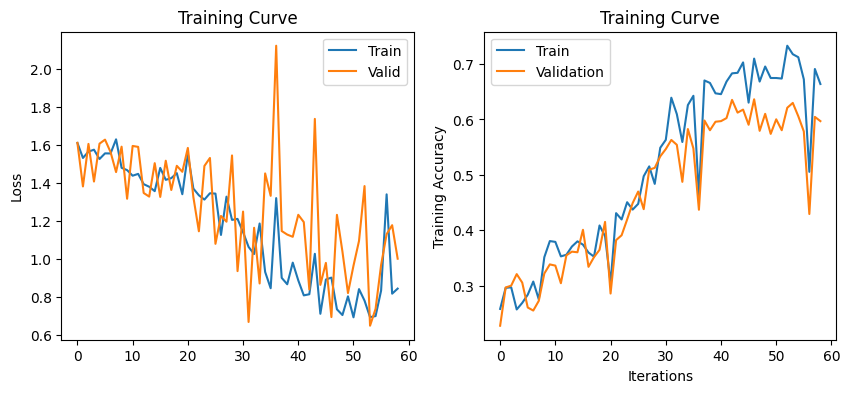

Final Training Accuracy: 0.6638696939782823
Final Validation Accuracy: 0.5969331872946331


In [218]:
train_loss = [x.cpu() for x in train_loss]
valid_loss = [x.cpu() for x in valid_loss]
plot_metrics(train_loss, valid_loss, train_acc, valid_acc)

#### Wnioski - learning rate = 0.005 jest za duży

### Dla hidden = 100, layer = 2, learning rate = 0.001

In [219]:
model = LSTM_Seq_Regressor(1, 100, 2, 5, bidirectional=False, drop_out=0.3).to(device)
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

In [222]:
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc, learning_rate=0.001)

Epoch: 0, loss train: 1.29, loss valid: 1.5277773141860962
Accuracy train: 0.4368213228035538
Accuracy valid: 0.39868565169769987
Epoch: 10, loss train: 1.02, loss valid: 0.8740471005439758
Accuracy train: 0.5572556762092794
Accuracy valid: 0.52026286966046
Epoch: 20, loss train: 1.11, loss valid: 1.0475717782974243
Accuracy train: 0.5602171767028628
Accuracy valid: 0.5125958378970427
Epoch: 30, loss train: 0.989, loss valid: 1.1693618297576904
Accuracy train: 0.5908193484698914
Accuracy valid: 0.5717415115005476
Epoch: 40, loss train: 0.923, loss valid: 1.0658915042877197
Accuracy train: 0.5903257650542941
Accuracy valid: 0.5345016429353778
Epoch: 50, loss train: 0.98, loss valid: 0.8940649628639221
Accuracy train: 0.6071076011846002
Accuracy valid: 0.5454545454545454
Epoch: 60, loss train: 0.995, loss valid: 1.2352410554885864
Accuracy train: 0.5863770977295163
Accuracy valid: 0.5301204819277109
Epoch: 70, loss train: 0.947, loss valid: 1.8651584386825562
Accuracy train: 0.5409674234

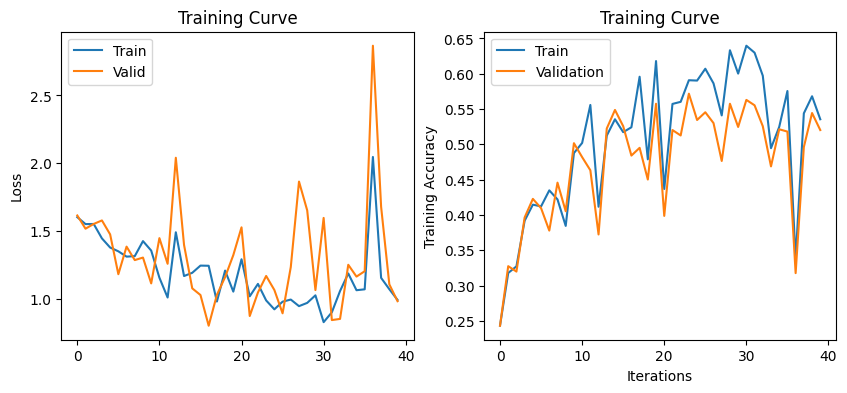

Final Training Accuracy: 0.5355380059230009
Final Validation Accuracy: 0.52026286966046


In [223]:
train_loss = [x.cpu() for x in train_loss]
valid_loss = [x.cpu() for x in valid_loss]
plot_metrics(train_loss, valid_loss, train_acc, valid_acc)

### Dla hidden = 40, layer = 2, learning rate = 0.002

In [45]:
model = LSTM_Seq_Regressor(1, 40, 2, 5, bidirectional=False, drop_out=0.3).to(device)
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

In [48]:
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc, learning_rate=0.002)

Epoch: 0, loss train: 0.894, loss valid: 1.2151155471801758
Accuracy train: 0.6554787759131293
Accuracy valid: 0.5629791894852135
Epoch: 10, loss train: 0.887, loss valid: 1.3185776472091675
Accuracy train: 0.6791707798617966
Accuracy valid: 0.5706462212486308
Epoch: 20, loss train: 0.92, loss valid: 0.8192285299301147
Accuracy train: 0.6253701875616979
Accuracy valid: 0.5334063526834611
Epoch: 30, loss train: 0.823, loss valid: 0.8957592248916626
Accuracy train: 0.6510365251727542
Accuracy valid: 0.5772179627601315
Epoch: 40, loss train: 1.01, loss valid: 1.0376639366149902
Accuracy train: 0.6515301085883515
Accuracy valid: 0.5662650602409639
Epoch: 50, loss train: 1.16, loss valid: 1.0977438688278198
Accuracy train: 0.6411648568608095
Accuracy valid: 0.579408543263965
Epoch: 60, loss train: 0.716, loss valid: 0.9331713318824768
Accuracy train: 0.6732477788746298
Accuracy valid: 0.588170865279299
Epoch: 70, loss train: 0.944, loss valid: 1.2523932456970215
Accuracy train: 0.6623889437

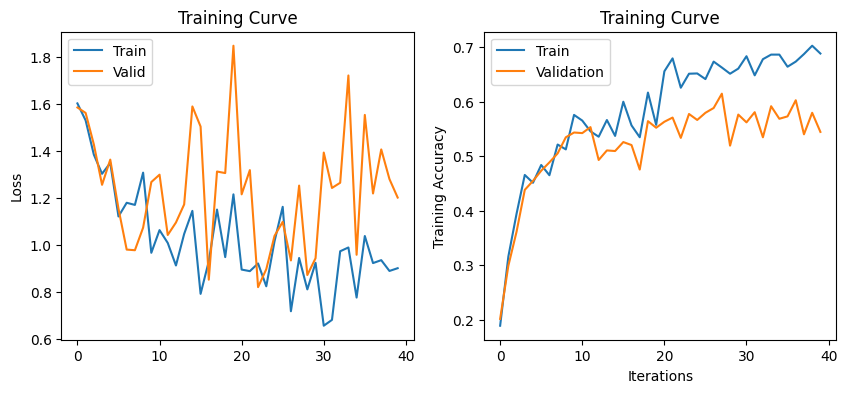

Final Training Accuracy: 0.6880552813425469
Final Validation Accuracy: 0.5443592552026287


In [49]:
train_loss = [x.cpu() for x in train_loss]
valid_loss = [x.cpu() for x in valid_loss]
plot_metrics(train_loss, valid_loss, train_acc, valid_acc)

#### Wnioski - modele z dwoma warstwami nie uczą się dobrze na podanych danych

### Dla Hidden = 100 layer = 1 learning rate = 0.001

In [226]:
model = LSTM_Seq_Regressor(1, 100, 1, 5, bidirectional=False, drop_out=0.3).to(device)
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

In [229]:
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc, learning_rate=0.001)

Epoch: 0, loss train: 0.744, loss valid: 1.0299787521362305
Accuracy train: 0.6688055281342546
Accuracy valid: 0.5914567360350493
Epoch: 10, loss train: 0.568, loss valid: 0.8979161381721497
Accuracy train: 0.7606120434353406
Accuracy valid: 0.6473165388828039
Epoch: 20, loss train: 0.677, loss valid: 0.7741166353225708
Accuracy train: 0.7221125370187562
Accuracy valid: 0.624315443592552
Epoch: 30, loss train: 0.942, loss valid: 1.4752492904663086
Accuracy train: 0.6614017769002961
Accuracy valid: 0.6089813800657174
Epoch: 40, loss train: 0.59, loss valid: 0.6260695457458496
Accuracy train: 0.7640671273445212
Accuracy valid: 0.6363636363636364
Epoch: 50, loss train: 0.624, loss valid: 1.263911485671997
Accuracy train: 0.7611056268509379
Accuracy valid: 0.6265060240963856
Epoch: 60, loss train: 0.772, loss valid: 0.9251794219017029
Accuracy train: 0.7586377097729516
Accuracy valid: 0.6429353778751369
Epoch: 70, loss train: 0.549, loss valid: 0.8473443984985352
Accuracy train: 0.79318854

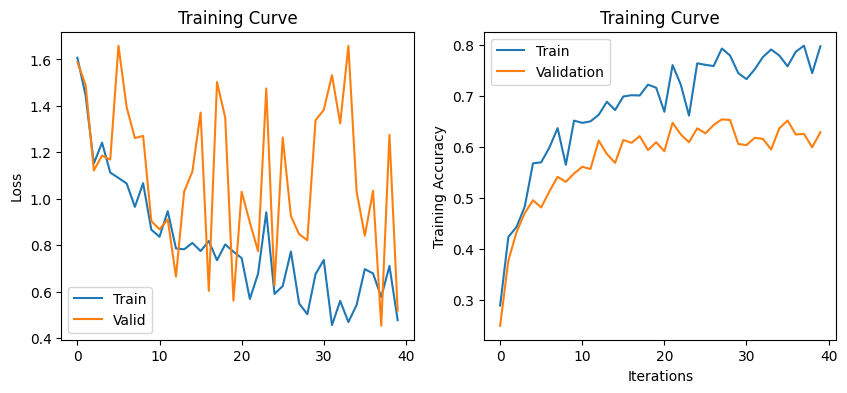

Final Training Accuracy: 0.7976307996051333
Final Validation Accuracy: 0.628696604600219


In [230]:
train_loss = [x.cpu() for x in train_loss]
valid_loss = [x.cpu() for x in valid_loss]
plot_metrics(train_loss, valid_loss, train_acc, valid_acc)

### Hidden = 100 layer = 1 biddirectional = True

In [232]:
model = LSTM_Seq_Regressor(1, 100, 1, 5, bidirectional=True).to(device)
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

In [236]:
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc, learning_rate=0.001)

Epoch: 0, loss train: 0.605, loss valid: 1.048813819885254
Accuracy train: 0.7334649555774926
Accuracy valid: 0.619934282584885
Epoch: 10, loss train: 0.677, loss valid: 0.8581575155258179
Accuracy train: 0.730009871668312
Accuracy valid: 0.6593647316538883
Epoch: 20, loss train: 0.722, loss valid: 1.2646098136901855
Accuracy train: 0.7438302073050346
Accuracy valid: 0.6319824753559693
Epoch: 30, loss train: 0.815, loss valid: 1.5030854940414429
Accuracy train: 0.7349457058242843
Accuracy valid: 0.6100766703176341
Epoch: 40, loss train: 0.679, loss valid: 1.0987077951431274
Accuracy train: 0.7566633761105627
Accuracy valid: 0.6473165388828039
Epoch: 50, loss train: 0.646, loss valid: 1.318651556968689
Accuracy train: 0.7388943731490621
Accuracy valid: 0.6451259583789705
Epoch: 60, loss train: 0.607, loss valid: 0.8709837198257446
Accuracy train: 0.7650542941757157
Accuracy valid: 0.6692223439211391
Epoch: 70, loss train: 0.739, loss valid: 0.6339283585548401
Accuracy train: 0.741855873

KeyboardInterrupt: 

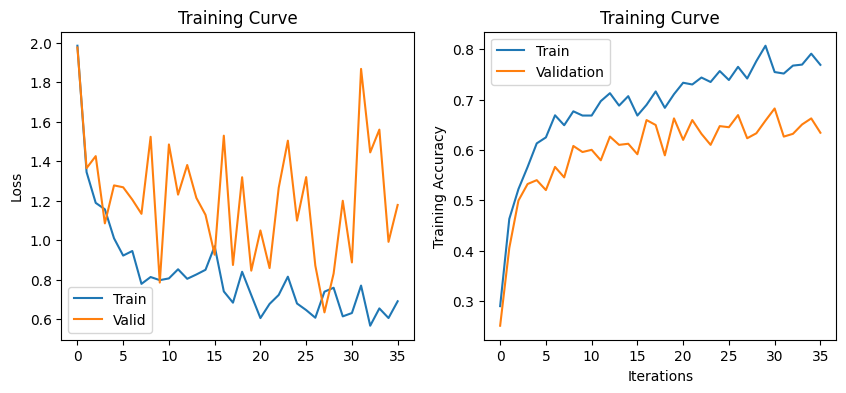

Final Training Accuracy: 0.7690029615004936
Final Validation Accuracy: 0.6341730558598029


In [237]:
train_loss = [x.cpu() for x in train_loss]
valid_loss = [x.cpu() for x in valid_loss]
plot_metrics(train_loss, valid_loss, train_acc, valid_acc)

#### Wnioski - modele przeuczają się (overfitting) możliwe, że jest to spowodowane samplowaniem, w którym mało liczne klasy są często losowane z powtórzeniami

### Dla hidden = 100, layer = 2, learning rate = 0.001

In [238]:
model = LSTM_Seq_Regressor(1, 60, 1, 5, bidirectional=True).to(device)
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

In [249]:
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc, learning_rate=0.001)

Epoch: 0, loss train: 0.681, loss valid: 0.7351662516593933
Accuracy train: 0.7660414610069102
Accuracy valid: 0.6812705366922235
Epoch: 10, loss train: 0.853, loss valid: 0.7768436670303345
Accuracy train: 0.6796643632773939
Accuracy valid: 0.5651697699890471
Epoch: 20, loss train: 0.621, loss valid: 0.6494290232658386
Accuracy train: 0.7778874629812438
Accuracy valid: 0.6571741511500547
Epoch: 30, loss train: 0.639, loss valid: 1.1152063608169556
Accuracy train: 0.78035538005923
Accuracy valid: 0.6166484118291348
Epoch: 40, loss train: 0.727, loss valid: 1.159533977508545
Accuracy train: 0.7872655478775913
Accuracy valid: 0.6276013143483024
Epoch: 50, loss train: 0.702, loss valid: 0.6050158143043518
Accuracy train: 0.7857847976307996
Accuracy valid: 0.6506024096385542
Epoch: 60, loss train: 0.575, loss valid: 0.6802229881286621
Accuracy train: 0.7798617966436328
Accuracy valid: 0.6703176341730559
Epoch: 70, loss train: 0.652, loss valid: 1.7582818269729614
Accuracy train: 0.75123395

KeyboardInterrupt: 

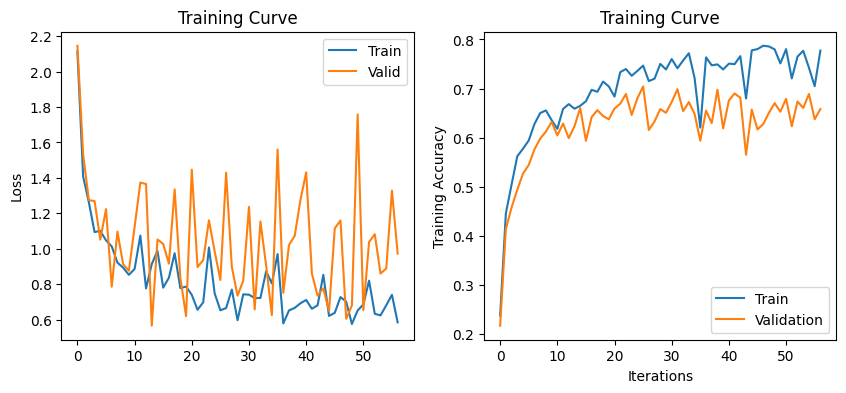

Final Training Accuracy: 0.7773938795656465
Final Validation Accuracy: 0.6582694414019715


In [250]:
train_loss = [x.cpu() for x in train_loss]
valid_loss = [x.cpu() for x in valid_loss]
plot_metrics(train_loss, valid_loss, train_acc, valid_acc)

#### Wnioski - po zmniejszeniu rozmiaru stanu hidden do 60 model mniej się przeucza

### Próba wyszkolenia modelu o wielu powłokach - layer = 4

In [66]:
model = LSTM_Seq_Regressor(1, 40, 4, 5, bidirectional=False, drop_out=0.3).to(device)
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

In [67]:
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc, learning_rate=0.006)

Epoch: 0, loss train: 1.61, loss valid: 1.6027950048446655
Accuracy train: 0.20088845014807502
Accuracy valid: 0.18072289156626506
Epoch: 10, loss train: 1.61, loss valid: 1.609432339668274
Accuracy train: 0.20533070088845015
Accuracy valid: 0.1851040525739321
Epoch: 20, loss train: 1.61, loss valid: 1.6091690063476562
Accuracy train: 0.1870681145113524
Accuracy valid: 0.18619934282584885
Epoch: 30, loss train: 1.61, loss valid: 1.6094386577606201
Accuracy train: 0.19743336623889438
Accuracy valid: 0.21686746987951808
Epoch: 40, loss train: 1.61, loss valid: 1.6089390516281128
Accuracy train: 0.19397828232971373
Accuracy valid: 0.19605695509309967
Epoch: 50, loss train: 1.61, loss valid: 1.6088507175445557
Accuracy train: 0.19595261599210267
Accuracy valid: 0.20153340635268346
Epoch: 60, loss train: 1.61, loss valid: 1.6098238229751587
Accuracy train: 0.20039486673247778
Accuracy valid: 0.21139101861993428
Epoch: 70, loss train: 1.61, loss valid: 1.609440565109253
Accuracy train: 0.203

KeyboardInterrupt: 

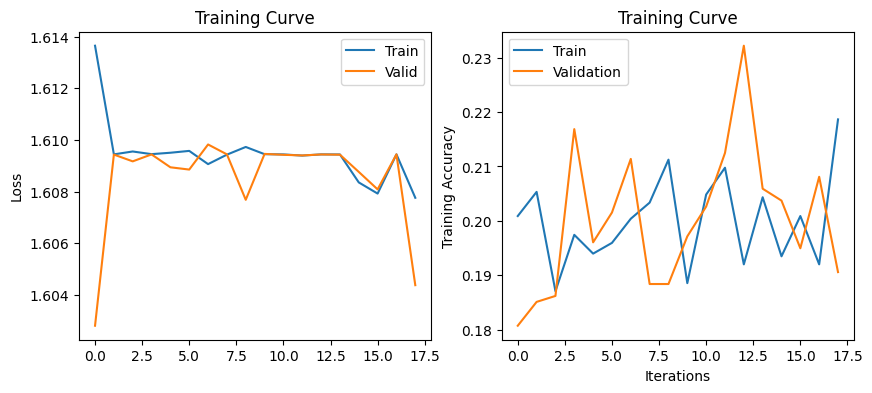

Final Training Accuracy: 0.21865745310957552
Final Validation Accuracy: 0.19058050383351588


In [68]:
train_loss = [x.cpu() for x in train_loss]
valid_loss = [x.cpu() for x in valid_loss]
plot_metrics(train_loss, valid_loss, train_acc, valid_acc)

#### Wnioski - przy danym laerning rate model nie uczy się

## Dla samplowania bez powtórzeń

In [77]:
sampler_train = torch.utils.data.WeightedRandomSampler(samples_weights_train, len(samples_weights_train), replacement=False)
sampler_valid = torch.utils.data.WeightedRandomSampler(samples_weights_valid, len(samples_weights_valid), replacement=False)
train_loader = DataLoader(train_set, batch_size=128, collate_fn=pad_collate, sampler=sampler_train)
valid_loader = DataLoader(valid_set, batch_size=128, collate_fn=pad_collate, shuffle=sampler_valid)

In [78]:
model = LSTM_Seq_Regressor(1, 100, 1, 5, bidirectional=True).to(device)
model

LSTM_Seq_Regressor(
  (lstm): LSTM(1, 100, proj_size=5, bidirectional=True)
  (fc2): Linear(in_features=100, out_features=5, bias=True)
)

In [79]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

In [87]:
train_model(model, train_loader, valid_loader, train_loss, valid_loss, train_acc, valid_acc)

Epoch: 0, loss train: 0.258, loss valid: 1.1559885740280151
Accuracy train: 0.6461006910167818
Accuracy valid: 0.6484118291347207
Epoch: 10, loss train: 0.403, loss valid: 1.2423897981643677
Accuracy train: 0.7211253701875617
Accuracy valid: 0.6976998904709748
Epoch: 20, loss train: 0.34, loss valid: 0.9712462425231934
Accuracy train: 0.7053307008884502
Accuracy valid: 0.6911281489594743
Epoch: 30, loss train: 0.337, loss valid: 0.8744661211967468
Accuracy train: 0.7137216189536032
Accuracy valid: 0.6955093099671413
Epoch: 40, loss train: 0.319, loss valid: 1.046557068824768
Accuracy train: 0.7245804540967423
Accuracy valid: 0.6987951807228916
Epoch: 50, loss train: 0.299, loss valid: 1.196000099182129
Accuracy train: 0.7245804540967423
Accuracy valid: 0.7009857612267251
Epoch: 60, loss train: 0.281, loss valid: 0.5994483828544617
Accuracy train: 0.7270483711747285
Accuracy valid: 0.6955093099671413
Epoch: 70, loss train: 0.292, loss valid: 0.6751421093940735
Accuracy train: 0.72063178

In [88]:
train_loss = [x.cpu() for x in train_loss]
valid_loss = [x.cpu() for x in valid_loss]

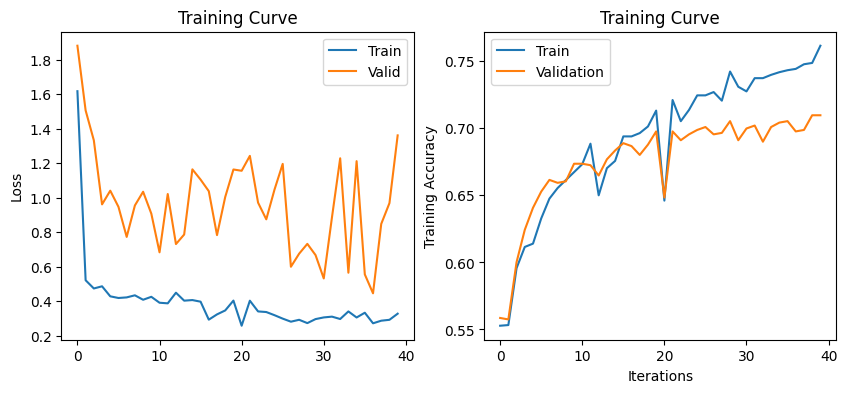

Final Training Accuracy: 0.7615992102665351
Final Validation Accuracy: 0.7097480832420592


In [89]:
plot_metrics(train_loss, valid_loss, train_acc, valid_acc)

#### Sprawdzanie na przykładzie z samplowaniem z powtórzeniami

In [253]:
sampler_train2 = torch.utils.data.WeightedRandomSampler(samples_weights_train, len(samples_weights_train), replacement=True)
sampler_valid2 = torch.utils.data.WeightedRandomSampler(samples_weights_valid, len(samples_weights_valid), replacement=True)
train_loader2 = DataLoader(train_set, batch_size=128, collate_fn=pad_collate, sampler=sampler_train2)
valid_loader2 = DataLoader(valid_set, batch_size=128, collate_fn=pad_collate, shuffle=sampler_valid2)

In [91]:
print(f'Train acc: {eval(train_loader2, model)[0]}')
print(f'Valid acc: {eval(valid_loader2, model)[0]}')

Train acc: 0.5449160908193484
Valid acc: 0.6998904709748083


In [92]:
torch.save(model.state_dict(), 'modelNoRepetitions.pt')

#### Wnioski - po samplowaniu bez powtórzeń udało uzyskać się wysoką skuteczność na zbiorze walidacyjnym, model gorzej radził sobie na zbiorze treningowym. Może to być spowodowane nie "obejrzeniem" przez model wszystkich próbek klasy większościowej

## Wnioski końcowe

Po przeprowadzonych eksperymentach najlepiej poradziła sobie model o przestrzeni hidden = 50, liczbie powłok równej 1 o architekturze bidirectional. Osiągnął on 69% skuteczności na zbiorze walidacyjnym przy samplowaniu z powtórzeniami.

In [263]:
model = LSTM_Seq_Regressor(1, 60, 1, 5, bidirectional=True).to(device)
model.load_state_dict(torch.load('model69%.pt'))
model.eval()

LSTM_Seq_Regressor(
  (lstm): LSTM(1, 60, proj_size=5, bidirectional=True)
  (fc2): Linear(in_features=60, out_features=5, bias=True)
)

In [261]:
print(f'Train acc: {eval(train_loader2, model)[0]}')
print(f'Valid acc: {eval(valid_loader2, model)[0]}')

Train acc: 0.7058242843040474
Valid acc: 0.6571741511500547


In [ ]:
model = 